# Supervised Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import os 

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, SpatialDropout1D

import matplotlib.pyplot as plt
import seaborn as sns

2024-09-07 12:29:32.313835: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 12:29:32.316835: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 12:29:32.335749: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 12:29:32.562798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 12:29:36.551327: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In this lab assignment, you will follow the machine learning life cycle and implement a model to solve a machine learning problem of your choosing. You will select a data set and choose a predictive problem that the data set supports.  You will then inspect the data with your problem in mind and begin to formulate a  project plan. You will then implement the machine learning project plan. 

You will complete the following tasks:

1. Build Your DataFrame
2. Define Your ML Problem
3. Perform exploratory data analysis to understand your data.
4. Define Your Project Plan
5. Implement Your Project Plan:
    * Prepare your data for your model.
    * Fit your model to the training data and evaluate your model.
    * Improve your model's performance.

## Building DataFrame

#### Loading ISEAR subset and Saving it as a Pandas DataFrame

In [2]:
df = pd.read_csv('isear.csv')

df.head(10)

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...
6,10947,anger,wanna go home and focus up on this game . Don'...
7,10948,anger,@virginmedia I've been disconnected whilst on ...
8,10949,anger,@virginmedia I've been disconnected whilst on ...
9,10950,anger,I wanna see you smile I don't wanna see you ma...


## Defining the ML Problem

1. The data set being used is a portion of the ISEAR dataset, which provides textual content and labels the content with a certain emotion. The portion used has an id column, a sentiment column, and a content column.
2. I will be predicting the sentiment of the text content. The textual content in the content column is the only feature and is a string. The sentiment content serves as the label and has four possible values: anger, fear, joy, sadness. 
3. This is a supervised learning problem because all the data points are labeled with their sentiment. This is a multi-class classification problem since there are more than two distinct, discrete classes (the classes are anger, fear, joy, sadness).
4. The only feature that will be used is the text content in the content column. The text data will be transformed into numerical features through vectorization.
5. This is a very important problem because a company can use this model to predict the sentiment of their customer reviews and gain insights into their experiences with a particular product or service. This will help them improve their product for higher satisfaction. Additionally, businesses can use this sentiment analysis tool to improve their marketing campaigns for a product after seeing the general sentiment surrounding an ad.

## Data Understanding

    * addressing missingness, such as replacing missing values with means
    * finding and replacing outliers
    * renaming features and labels
    * finding and replacing outliers
    * performing feature engineering techniques such as one-hot encoding on categorical features
    * selecting appropriate features and removing irrelevant features
    * performing specific data cleaning and preprocessing techniques for an NLP problem
    * addressing class imbalance in your data sample to promote fair AI

In [3]:
df.dtypes

ID            int64
sentiment    object
content      object
dtype: object

In [4]:
df.describe

<bound method NDFrame.describe of          ID sentiment                                            content
0     10941     anger  At the point today where if someone says somet...
1     10942     anger  @CorningFootball  IT'S GAME DAY!!!!      T MIN...
2     10943     anger  This game has pissed me off more than any othe...
3     10944     anger  @spamvicious I've just found out it's Candice ...
4     10945     anger  @moocowward @mrsajhargreaves @Melly77 @GaryBar...
...     ...       ...                                                ...
7097  40781   sadness  @VivienLloyd Thank you so much! Just home - st...
7098  40782   sadness              Just put the winter duvet on ☃️❄️🌬☔️ 
7099  40783   sadness  @SilkInSide @TommyJoeRatliff that's so pretty!...
7100  40784   sadness  @BluesfestByron second artist announcement loo...
7101  40785   sadness  I can literally eat creamy pesto pasta topped ...

[7102 rows x 3 columns]>

In [5]:
df.isnull().sum()

ID           0
sentiment    0
content      0
dtype: int64

sentiment
fear       2252
anger      1701
joy        1616
sadness    1533
Name: count, dtype: int64


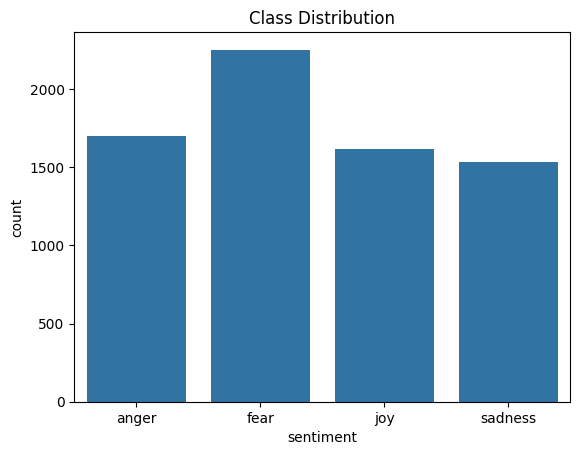

In [6]:
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

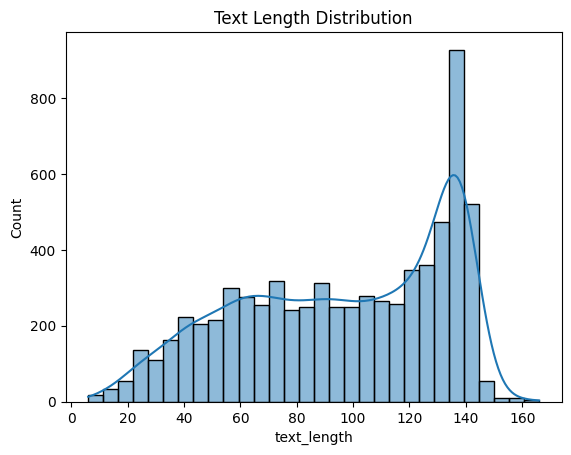

In [7]:
df['text_length'] = df['content'].apply(len)
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.show()

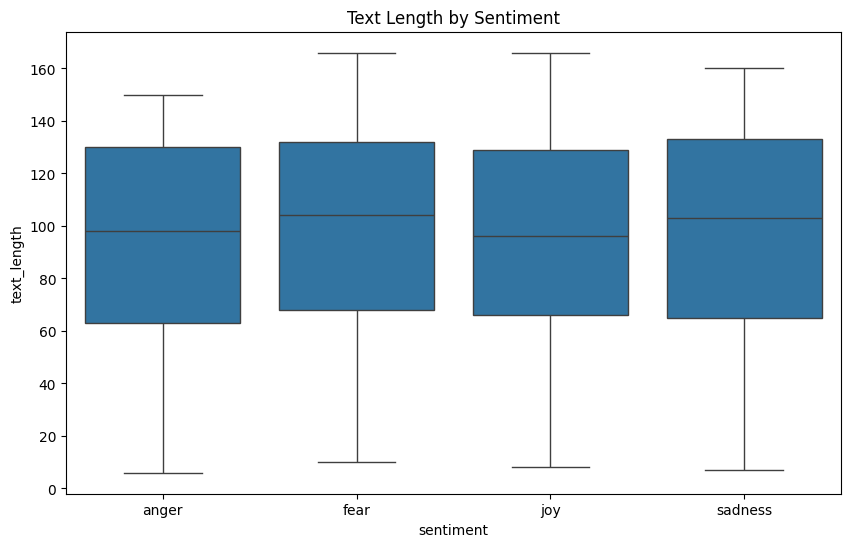

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Text Length by Sentiment')
plt.show()

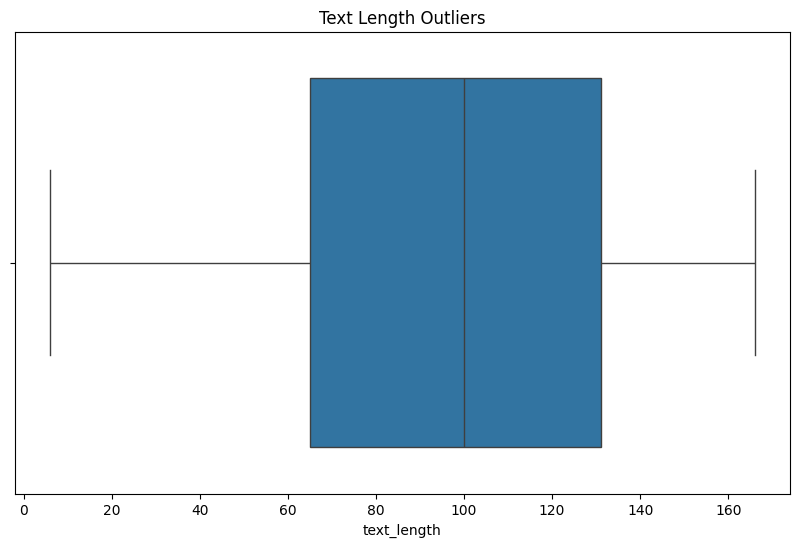

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='text_length', data=df)
plt.title('Text Length Outliers')
plt.show()

## Project Plan

- The main feature to keep is the content. It will be transformed into numeric data by using TF-IDF vectorization. The id column is not considered a feature since it doesn't contribute to predicting sentiment.
- For data preparation, I will remove any rows with missing values in the content or sentiment columns, since both are necessary for the analysis. For cleaning the content feature, I want to convert the text to lowercase, remove special characters, tokenize the text, remove stop words, and finally lemmatize the text.
- I want to compare multiple models like Logistic Regression (simple and easy to interpret), an SVM, Random Forest, and an LSTM.
- I will split the dataset into training and testing sets (80/20). Then I will train the different models on the training data using the processed content. Hyperparameters will be tuned by testing common parameters, or using Grid Search to find optimal hyparameters for a certain model. Finally, I will evaluate the model performance using different metrics (accuracy, precision, etc).

## Implementing Project Plan

In [10]:
# all libraries imported in the very first cell

**Preprocessing**

In [11]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    tokens = nltk.word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [12]:
df.dropna(subset=['content', 'sentiment'], inplace=True)
df['content'] = df['content'].apply(preprocess_text)
df.head()

,ID,sentiment,content,text_length
0,10941,anger,point today someone say something remotely kin...,109
1,10942,anger,corningfootball game day minus relentless,67
2,10943,anger,game pissed game year blood boiling time turn ...,115
3,10944,anger,spamvicious ive found candice candace pout like,101
4,10945,anger,moocowward mrsajhargreaves melly garybarlow ca...,135


In [13]:
vectorizer = TfidfVectorizer(max_features=5000)

In [14]:
X = vectorizer.fit_transform(df['content']).toarray()
y = df['sentiment']

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Logistic Regression**

In [17]:
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [18]:
y_pred_log = log_model.predict(X_test)

In [19]:
logistic_metrics = [accuracy_score(y_test, y_pred_log), 
                    precision_score(y_test, y_pred_log, average='weighted'), 
                    recall_score(y_test, y_pred_log, average='weighted'), 
                    f1_score(y_test, y_pred_log, average='weighted')]
print("Logistic Regression Accuracy:", logistic_metrics[0])
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9112097669256382
Classification Report:
              precision    recall  f1-score   support

       anger       0.94      0.91      0.92       470
        fear       0.86      0.90      0.88       441
         joy       0.95      0.93      0.94       430
     sadness       0.90      0.90      0.90       461

    accuracy                           0.91      1802
   macro avg       0.91      0.91      0.91      1802
weighted avg       0.91      0.91      0.91      1802



In [20]:
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred_log)

Confusion Matrix:


array([[426,  19,   5,  20],
       [  9, 398,   8,  26],
       [  9,  18, 402,   1],
       [ 10,  28,   7, 416]])

**Random Forest**

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred_rf = rf.predict(X_test)

In [23]:
rf_metrics = [accuracy_score(y_test, y_pred_rf), 
              precision_score(y_test, y_pred_rf, average='weighted'), 
              recall_score(y_test, y_pred_rf, average='weighted'), 
              f1_score(y_test, y_pred_rf, average='weighted')]
print("Random Forest Accuracy:",rf_metrics[0])
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8723640399556049
Classification Report:
              precision    recall  f1-score   support

       anger       0.95      0.82      0.88       470
        fear       0.73      0.91      0.81       441
         joy       0.97      0.91      0.94       430
     sadness       0.89      0.85      0.87       461

    accuracy                           0.87      1802
   macro avg       0.88      0.87      0.88      1802
weighted avg       0.88      0.87      0.87      1802



In [24]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Confusion Matrix:
[[386  59   3  22]
 [  7 402   4  28]
 [  4  34 392   0]
 [ 10  53   6 392]]


**SVM**

In [25]:
svm = SVC()
param_grid = {'C':[0.1, 1, 10], 'kernel':['linear']}
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.784 total time= 6.9min
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.801 total time= 6.8min
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.810 total time= 6.8min
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.777 total time= 6.7min
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.792 total time= 6.5min
[CV 1/5] END ................C=1, kernel=linear;, score=0.895 total time= 4.0min
[CV 2/5] END ................C=1, kernel=linear;, score=0.900 total time= 3.9min
[CV 3/5] END ................C=1, kernel=linear;, score=0.908 total time= 4.0min
[CV 4/5] END ................C=1, kernel=linear;, score=0.899 total time= 3.9min
[CV 5/5] END ................C=1, kernel=linear;, score=0.897 total time= 3.9min
[CV 1/5] END ...............C=10, kernel=linear;, score=0.883 total time= 3.3min
[CV 2/5] END ...............C=10, kernel=linear;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear']}, verbose=3)

In [26]:
best_svm = grid_search.best_estimator_
best_svm

SVC(C=1, kernel='linear')

In [27]:
y_pred_svm = best_svm.predict(X_test)

In [28]:
svm_metrics = [accuracy_score(y_test, y_pred_svm), 
               precision_score(y_test, y_pred_svm, average='weighted'), 
               recall_score(y_test, y_pred_svm, average='weighted'), 
               f1_score(y_test, y_pred_svm, average='weighted')]
print("SVM Accuracy:", svm_metrics[0])
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9211986681465039
Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.90      0.93       470
        fear       0.87      0.91      0.89       441
         joy       0.97      0.95      0.96       430
     sadness       0.90      0.92      0.91       461

    accuracy                           0.92      1802
   macro avg       0.92      0.92      0.92      1802
weighted avg       0.92      0.92      0.92      1802



In [29]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Confusion Matrix:
[[425  20   4  21]
 [  7 402   5  27]
 [  5  16 409   0]
 [  8  25   4 424]]


**Comparison of Results**

In [33]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [logistic_metrics[0], rf_metrics[0], svm_metrics[0]],
    'Precision': [logistic_metrics[1], rf_metrics[1], svm_metrics[1]],
    'Recall': [logistic_metrics[2], rf_metrics[2], svm_metrics[2]],
    'F1 Score': [logistic_metrics[3], rf_metrics[3], svm_metrics[3]]
})

print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.911210   0.912278  0.911210  0.911523
1        Random Forest  0.872364   0.884742  0.872364  0.874706
2                  SVM  0.921199   0.922668  0.921199  0.921571


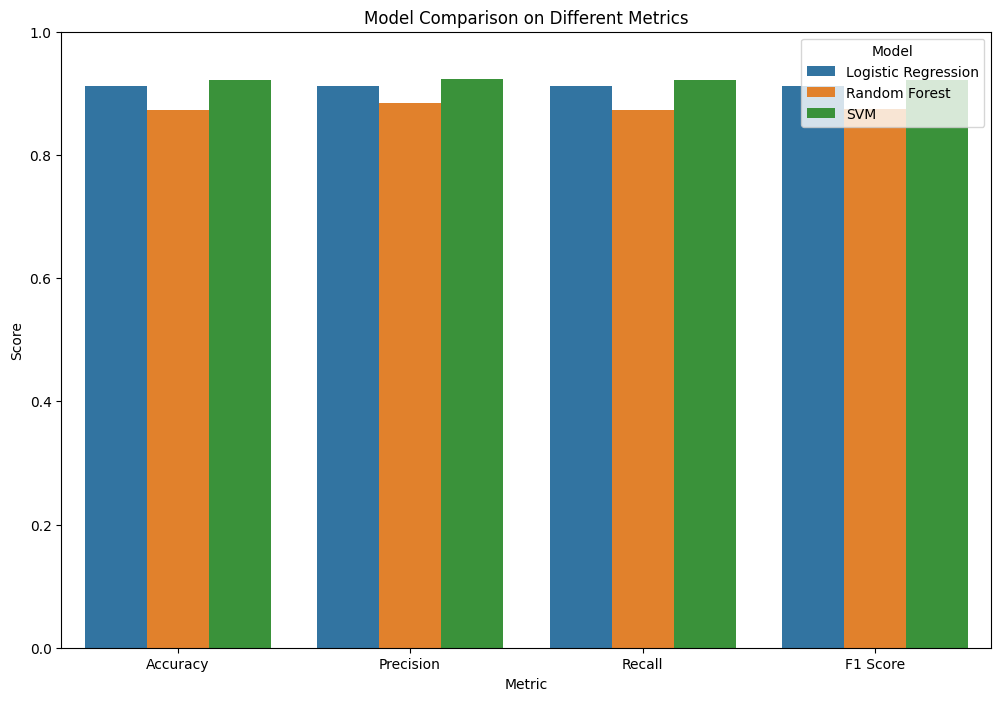

In [34]:
plt.figure(figsize=(12, 8))

metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted)
plt.title('Model Comparison on Different Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

**From the graph above we can clearly see that SVM performs the best in all metrics, however Logistic Regression is very close to being the best. While, SVM did perform the best, the downside is the very long training time (especially when tuning hyperparameters). Logistic Regression is simple to implement and easy to interpret. SVMs likely did so well because it is suited to vectorized text data; it might be the case that Random Forest was not well-suited to vectorization.**